# Hardware Details 
```
$ sudo ipmctl show -topology
 DimmID | MemoryType                  | Capacity    | PhysicalID| DeviceLocator
================================================================================
 0x0001 | Logical Non-Volatile Device | 126.375 GiB | 0x0032    | DIMM_P0_A1
 0x1001 | Logical Non-Volatile Device | 126.375 GiB | 0x0044    | DIMM_P1_G1
 N/A    | DDR4                        | 16.000 GiB  | 0x0030    | DIMM_P0_A0
 N/A    | DDR4                        | 16.000 GiB  | 0x0034    | DIMM_P0_B0
 N/A    | DDR4                        | 16.000 GiB  | 0x0042    | DIMM_P1_G0
 N/A    | DDR4                        | 16.000 GiB  | 0x0046    | DIMM_P1_H0
 ```
 
 
 ```
 ------------- Machine information -------------
CPU model name: Intel(R) Xeon(R) Gold 5218 CPU @ 2.30GHz
rdtsc/perfc frequency: 2300000 K cycles per second
 -- TLB info --
DTLB: 4 entries for 1GB, 4-way
DTLB: 64 entries for 4KB, 4-way
ITLB: 8 entries for 2MB or 4MB, full
ITLB: 64 entries for 4KB, 8-way
STLB: 1536 entries for 4KB and 2MB, 6-way, shared 2nd level. Also 16 entries for 1GB, 4-way                                                                                          
 -- Cache info --
DCACHE: lvl 1, 32 KB, sets:64, linesz:64, part:1, ways:8
ICACHE: lvl 1, 32 KB, sets:64, linesz:64, part:1, ways:8
CACHE: lvl 2, 1024 KB, sets:1024, linesz:64, part:1, ways:16
CACHE: lvl 3, 22528 KB, sets:32768, linesz:64, part:1, ways:11
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def concat(fields, fd):
    return fd[fields].T.values

def pool(name, df):
     return df[df['pool'] == name].drop(columns=["pool"])

def rw_ratio(ratio, df):
     return df[df['rw_ratio'] == ratio].drop(columns=["rw_ratio"])

def ws(v, df):
    return df[df['ws'] == v].drop(columns=['ws'])

def threads(i, df):
    return df[df['threads'] == i].drop(columns=['threads'])

def merge_ratios(fd, ratios=[
            (100, 'ro'),
            (66, 'rrw'),
            (50, 'rw'),
            (33, 'rww'),
            (0, 'wo')]):
    m = fd["threads"].drop_duplicates()
    for r, n in ratios:
        t = rw_ratio(r, fd).rename(columns={'ltc':n,'ltc_d':n+'_d'})
        m = pd.merge(m, t)
    return m

def plot_ratios(fd, axs):
    fd = merge_ratios(fd)
    labels=['ro','rrw','rw','rww','wo']
    fd.plot(
        ax=axs,
        x='threads',
        ylabel='latency (ns)',
        y=labels,
        yerr=concat([x + '_d' for x in labels], fd))

In [9]:
data = pd.read_csv('pmbench.csv', delimiter = ",")
data

,date,pool,threads,sz,ws,rw_ratio,ltc,ltc_d,offset,pattern,mode
0,Apr 27 09:41:01,fsdax,1,256,128,0,181,0.00,uniform,random,App
1,Apr 27 09:41:12,ram_l,1,256,128,0,32,0.00,uniform,random,App
2,Apr 27 09:41:23,ram_r,1,256,128,0,38,0.00,uniform,random,App
3,Apr 27 09:41:34,pm_l,1,256,128,0,179,0.00,uniform,random,App
4,Apr 27 09:41:45,pm_r,1,256,128,0,274,0.00,uniform,random,App
...,...,...,...,...,...,...,...,...,...,...,...
2215,May 2 21:11:09,ram_l,25,67488,33744,50,1200,113.33,uniform,random,Mem100
2216,May 2 21:13:13,ram_l,29,67488,33744,0,2220,289.78,uniform,random,Mem100
2217,May 2 21:15:01,ram_l,29,67488,33744,50,1435,92.53,uniform,random,Mem100
2218,May 2 21:17:17,ram_l,33,67488,33744,0,2511,260.98,uniform,random,Mem100


# AppMode plots

Next plots shows latency caracteristics for diiferent application mode setups.
Several key points:
- 'remote'/'local' denotes used _NUMA_ memory node;
- all threads were binded to on node;
- _fsdax_ plot shows OS overhead for _DAX_ enabled file system;
- vertical bars show latency difference for different threads in particular test run.

In [10]:
apps = data[
    (data["offset"] == "uniform") &
    (data['pattern'] == "random") &
    (data['mode'] == "App") &
    True].drop(columns=["offset","pattern","mode","sz","ws","date"])

apps_fsdax = pool('fsdax', apps)
apps_ram_l = pool('ram_l', apps)
apps_ram_r = pool('ram_r', apps)
apps_pm_r  = pool('pm_r',  apps)
apps_pm_l  = pool('pm_l',  apps)

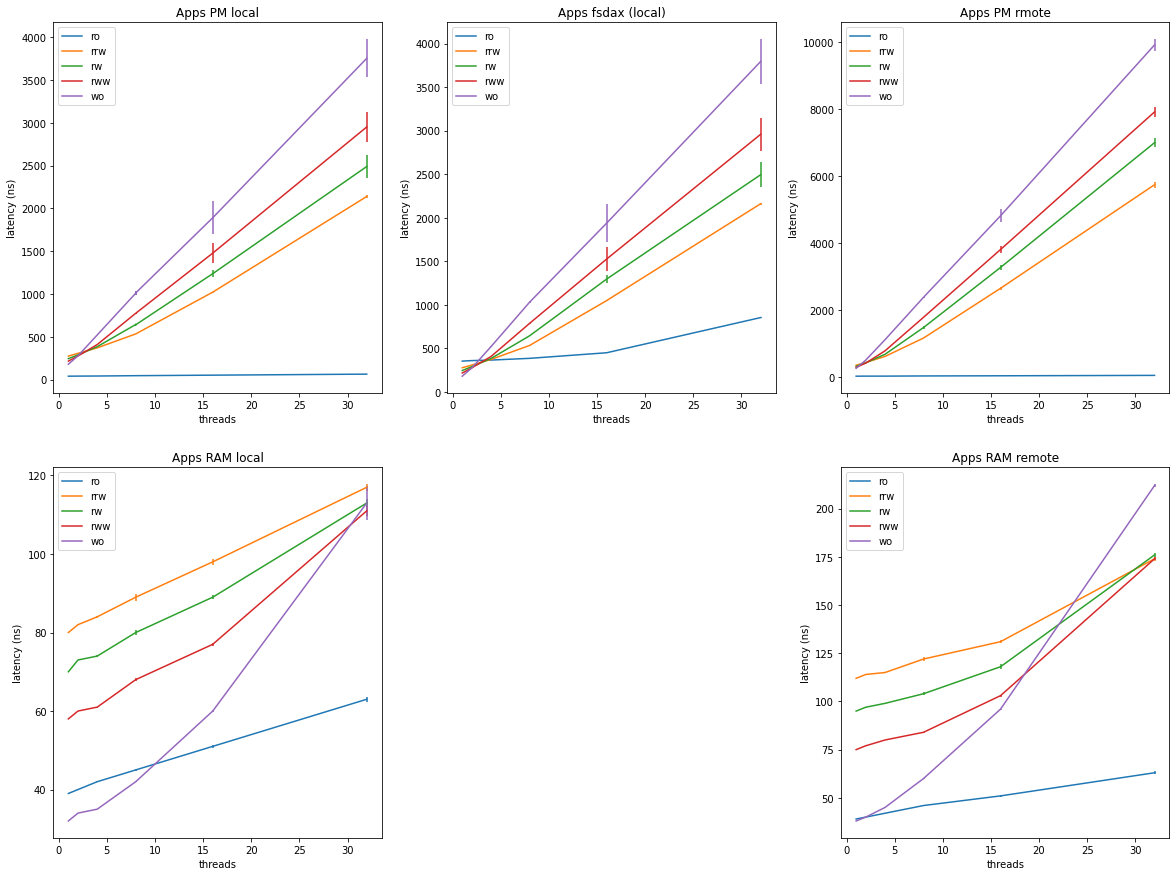

In [10]:
fig = plt.figure(figsize=(20,15))
for v, n, i in [
        (apps_pm_l, "Apps PM local", 1),
        (apps_fsdax, "Apps fsdax (local)", 2),
        (apps_pm_r, "Apps PM rmote", 3),
        (apps_ram_l, "Apps RAM local", 4),
        (apps_ram_r, "Apps RAM remote", 6)]:
    ax = fig.add_subplot(2, 3, i)
    ax.set_title(n)
    plot_ratios(v, ax)

# Full memory mode
Next few plots present various latency characteristics for memory mode

In [5]:
mem100 = data[
    (data['mode'] == 'Mem100') &
    (data['date'].str.contains('May  2')) &
    True].drop(columns = [
        'pool',
        'offset',
        'pattern',
        'mode',
        'sz',
        ]).sort_values(["threads","ws"])

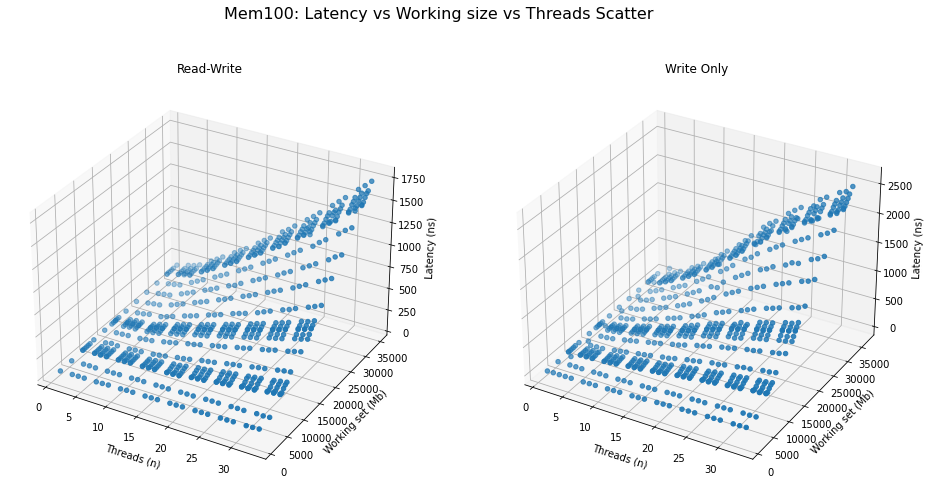

In [6]:
i = 0
fig = plt.figure(figsize=(16,8))
fig.suptitle('Mem100: Latency vs Working size vs Threads Scatter', fontsize=16)
for r, nm in [(50, 'Read-Write'), (0, 'Write Only')]:
    i += 1
    d = rw_ratio(r, mem100)
    ax = fig.add_subplot(1, 2, i, projection='3d')
    ax.scatter3D(d['threads'], d['ws'], d['ltc'])
    ax.set_title(nm)
    ax.set_xlabel('Threads (n)')
    ax.set_ylabel('Working set (Mb)')
    ax.set_zlabel('Latency (ns)')

## Read Write Saturation
Next two plots aimed to find thread sturation for constant wokring set.
Left one contain working set fitting into the DRAM, right one doesn't fit.
High error bars doesn't look obvious.

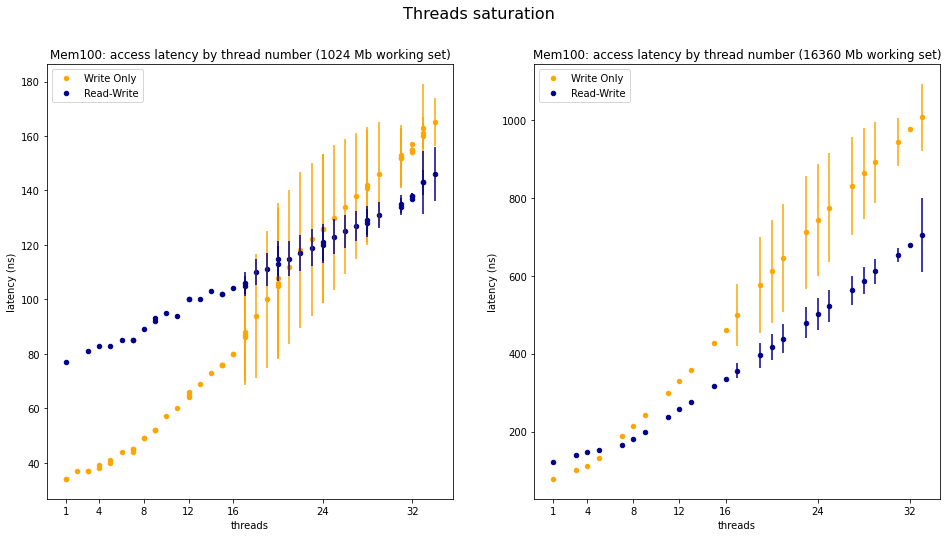

In [24]:
def plot_mem100_wsz(wsz, ax):
    ax.set_title('Mem100: access latency by thread number ({} Mb working set)'.format(wsz))
    ax.set_xticks([1, 4, 8, 12, 16, 24, 32, 36])
    for r, n, c in [ (0, 'Write Only', 'Orange'), (50, 'Read-Write', 'DarkBlue')]:
        ws(wsz, rw_ratio(r, mem100)) \
            .plot.scatter(
                ax = ax,
                x = 'threads',
                y = 'ltc',
                yerr = 'ltc_d',
                ylabel = 'latency (ns)',
                c = c, 
                label = n,
            )
    ax.legend(loc='upper left')
        
fig = plt.figure(figsize=(16,8))
fig.suptitle('Threads saturation', fontsize=16)
ax = fig.subplots(1, 2)
plot_mem100_wsz(1024, ax[0])
plot_mem100_wsz(16360, ax[1])

# Latency from working set
Next one tries to nail down edge of performance drop with growing working set.

For some reason I can't see this drop for one thread run.

Right plot witnesess 4Gb threshold visible when we switch thread number.


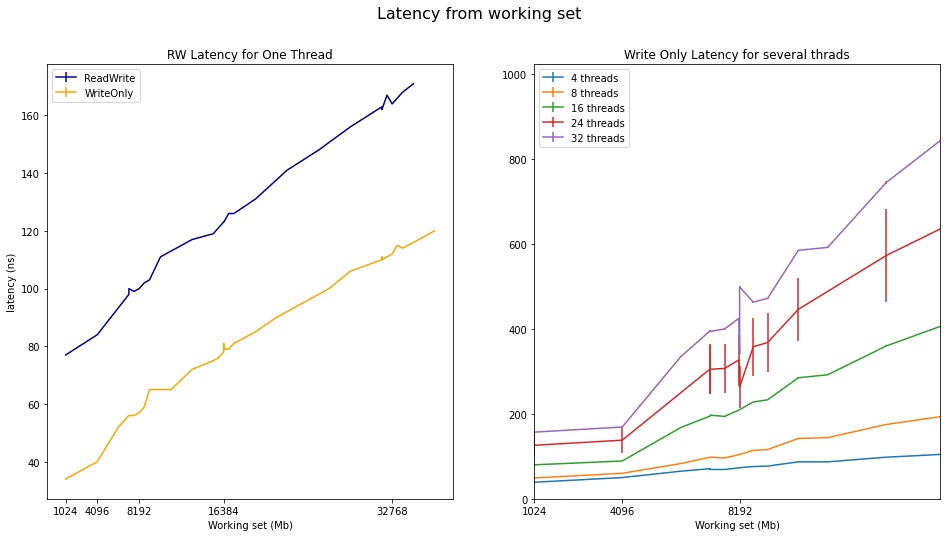

In [21]:
mem100 = data[
    (data['mode'] == 'Mem100') &
    (~data['date'].str.contains('Apr 28 09')) & # extremely slow values, can't explain, let's just exclude for now
    (~data['date'].str.contains('Apr 28 10')) &
    True].drop(columns = [
        'pool',
        'offset',
        'pattern',
        'mode',
        'sz',
        ]).sort_values(["threads","ws"])

fig = plt.figure(figsize=(16,8))
fig.suptitle('Latency from working set', fontsize=16)
ax = fig.subplots(1, 2)
for a in ax:
    a.set_xticks([1024, 4*1024, 8*1024, 16*1024, 32*1024])

ax[0].set_title('RW Latency for One Thread')
ax[0].set_ylabel('latency (ns)')
p = threads(1, rw_ratio(50, mem100)).plot(x='ws', y='ltc', yerr='ltc_d', ax=ax[0], label='ReadWrite', c='DarkBlue')
p = threads(1, rw_ratio(0, mem100)).plot(x='ws', y='ltc', yerr='ltc_d', ax=ax[0],label='WriteOnly', c='Orange')
t = ax[0].set_xlabel('Working set (Mb)')


ax[1].set_title('Write Only Latency for several thrads')
ax[1].set_xlim([1024, 15184])
ax[1].set_ylim([0, 1024])
p = threads(4, rw_ratio(0, mem100)).plot(x='ws', y='ltc', yerr='ltc_d', ax=ax[1], label='4 threads')
p = threads(8, rw_ratio(0, mem100)).plot(x='ws', y='ltc', yerr='ltc_d', ax=ax[1], label='8 threads')
p = threads(16, rw_ratio(0, mem100)).plot(x='ws', y='ltc', yerr='ltc_d', ax=ax[1], label='16 threads')
p = threads(24, rw_ratio(0, mem100)).plot(x='ws', y='ltc', yerr='ltc_d', ax=ax[1], label='24 threads')
p = threads(32, rw_ratio(0, mem100)).plot(x='ws', y='ltc', yerr='ltc_d', ax=ax[1], label='32 threads')
t = ax[1].set_xlabel('Working set (Mb)')